# Imports

In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from time import time
import seaborn as sns

# Utility Functions and Serialized K-Means Class

In [2]:
# Utility Functions
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def plot_digit(data, title=''):
    plt.figure(figsize=(4, 4))
    plt.imshow(data.reshape(28, 28), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()
    
def visualize_clusters(centroids, k):

    plt.figure(figsize=(2*k, 2))
    for i in range(k):
        plt.subplot(1, k, i+1)
        plt.imshow(centroids[i].reshape(28, 28), cmap='gray')
        plt.title(f'Cluster {i}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Parallel Implementation
class ParallelKMeans:
    def __init__(self):
        self.spark=SparkSession.builder \
        .appName(f"LogisticRegression_{4}") \
        .config("spark.executor.cores", 4) \
        .config("spark.default.parallelism", 4) \
        .config("spark.sql.shuffle.partitions",4) \
        .getOrCreate()
    #@staticmethod
    def parallelReadFile(self,filename):
        
        # Read CSV with header
        print('Reading data into RDD')
        df = self.spark.read.csv(filename, header=True, inferSchema=True)

        # Drop the 'label' column if it exists
        if 'label' in df.columns:
            df = df.drop('label')

        # Convert rows to Numpy arrays without casting
        rdd = df.rdd.map(lambda row: np.array(row))

        return rdd
    
    @staticmethod
    def parallelAssign2cluster(x, centroids):
        
        x = x.astype(np.float64)  # Ensure float type
        distances = [euclidean_distance(x, c) for c in centroids]
        return np.argmin(distances)


    def parallelKMeans(self,data, K, n_iter):
   
        # Cache data for better performance across iterations
       # data = data.cache()

        # Initialize random centroids
        n_features = len(data.first())
        centroids = np.random.randn(K, n_features)

        for iteration in range(n_iter):
            print(f"Iteration {iteration + 1}/{n_iter}")

            # Broadcast centroids to all workers
            centroids_broadcast = self.spark.sparkContext.broadcast(centroids)

            # Assign points to clusters (Map phase)
            point_cluster_pairs = data.map(
                lambda x: (
                    np.argmin([np.linalg.norm(x - c) for c in centroids_broadcast.value]),
                    (x, 1)
                )
            )

            # Calculate new centroids (Reduce phase)
            cluster_sums = point_cluster_pairs.reduceByKey(
                lambda a, b: (a[0] + b[0], a[1] + b[1])
            ).collect()

            # Update centroids from the collected results
            new_centroids = np.zeros_like(centroids)
            for k, (sum_points, count) in cluster_sums:
                if count > 0:
                    new_centroids[k] = sum_points / count
                else:
                    new_centroids[k] = centroids[k]

            # Release broadcast variable explicitly
            centroids_broadcast.unpersist()

            # Check for convergence
            if np.allclose(centroids, new_centroids):
                print(f"Converged after {iteration + 1} iterations")
                break

            centroids = new_centroids

        return centroids


    # Performance Evaluation Functions
    def evaluate_performance(self,data, k_values, n_workers_range, n_iter=20):
        filename = "tot_mnist_shuf.csv"
        results = []

        for k in k_values:
            print(f"\nTesting with K={k}")
            k_results = []
            base_time = None

            for n_workers in n_workers_range:
                print(f"Testing with {n_workers} workers")

                if hasattr(self, 'spark') and self.spark is not None:
                    self.spark.stop()

                # Configure Spark for different worker counts
                self.spark = SparkSession.builder \
                    .appName(f"LogisticRegression_{n_workers}") \
                    .config("spark.executor.cores", n_workers) \
                    .config("spark.default.parallelism", n_workers) \
                    .config("spark.sql.shuffle.partitions",n_workers) \
                    .getOrCreate()

                data=self.parallelReadFile(filename)


                # Run clustering
                start_time = time()
                centroids = self.parallelKMeans(data, k, n_iter)
                end_time = time()

                execution_time = end_time - start_time
                if base_time is None:
                    base_time = execution_time

                speedup = base_time / execution_time
                
                print(f'Execution time for {n_workers} cores:',execution_time)

                k_results.append({
                    'K': k,
                    'workers': n_workers,
                    'time': execution_time,
                    'speedup': speedup
                })
                self.spark.stop()
                self.spark=None

            results.extend(k_results)

        return pd.DataFrame(results)

def plot_performance_curves(results):
   
    plt.figure(figsize=(15, 5))
    
    # Performance curve
    plt.subplot(1, 2, 1)
    for k in results['K'].unique():
        k_data = results[results['K'] == k]
        plt.plot(k_data['workers'], k_data['time'], 
                marker='o', label=f'K={k}')
    plt.xlabel('Number of Workers')
    plt.ylabel('Execution Time (s)')
    plt.title('Performance Curve')
    plt.legend()
    
    # Speedup curve
    plt.subplot(1, 2, 2)
    for k in results['K'].unique():
        k_data = results[results['K'] == k]
        plt.plot(k_data['workers'], k_data['speedup'], 
                marker='o', label=f'K={k}')
    plt.xlabel('Number of Workers')
    plt.ylabel('Speedup Ratio')
    plt.title('Speedup Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



# Testing performance based on num_workers 


Testing Parallel Implementation...



Testing with K=3
Testing with 1 workers


Iteration 1/1


Execution time for 1 cores: 13.791811227798462
Testing with 2 workers


Iteration 1/1


Execution time for 2 cores: 7.27946138381958
Testing with 3 workers


Iteration 1/1


Execution time for 3 cores: 5.556073188781738
Testing with 4 workers


Iteration 1/1


Execution time for 4 cores: 6.349276065826416

Testing with K=5
Testing with 1 workers


Iteration 1/1


Execution time for 1 cores: 13.306213140487671
Testing with 2 workers


Iteration 1/1


Execution time for 2 cores: 7.904410362243652
Testing with 3 workers


Iteration 1/1


Execution time for 3 cores: 6.299434185028076
Testing with 4 workers


Iteration 1/1


Execution time for 4 cores: 6.052155256271362

Testing with K=7
Testing with 1 workers


Iteration 1/1


Execution time for 1 cores: 14.487311601638794
Testing with 2 workers


Iteration 1/1


Execution time for 2 cores: 8.43377161026001
Testing with 3 workers


Iteration 1/1


Execution time for 3 cores: 6.938745498657227
Testing with 4 workers


Iteration 1/1


Execution time for 4 cores: 7.051474332809448

Testing with K=8
Testing with 1 workers


Iteration 1/1


Execution time for 1 cores: 15.240622997283936
Testing with 2 workers


Iteration 1/1


Execution time for 2 cores: 8.710601568222046
Testing with 3 workers


Iteration 1/1


Execution time for 3 cores: 7.327807188034058
Testing with 4 workers


Iteration 1/1


Execution time for 4 cores: 6.847260475158691

Testing with K=9
Testing with 1 workers


Iteration 1/1


Execution time for 1 cores: 15.79097843170166
Testing with 2 workers


Iteration 1/1


Execution time for 2 cores: 9.904575109481812
Testing with 3 workers


Iteration 1/1


Execution time for 3 cores: 7.2226622104644775
Testing with 4 workers


Iteration 1/1


Execution time for 4 cores: 6.339353799819946

Testing with K=10
Testing with 1 workers


Iteration 1/1


Execution time for 1 cores: 16.91619610786438
Testing with 2 workers


Iteration 1/1


Execution time for 2 cores: 10.00406527519226
Testing with 3 workers


Iteration 1/1


Execution time for 3 cores: 7.911583185195923
Testing with 4 workers


Iteration 1/1


Execution time for 4 cores: 7.374760627746582

Testing with K=11
Testing with 1 workers


Iteration 1/1


Execution time for 1 cores: 17.11406373977661
Testing with 2 workers


Iteration 1/1


Execution time for 2 cores: 10.339322090148926
Testing with 3 workers


Iteration 1/1


Execution time for 3 cores: 8.026086330413818
Testing with 4 workers


Iteration 1/1


Execution time for 4 cores: 8.135539293289185

Plotting Performance Curves...


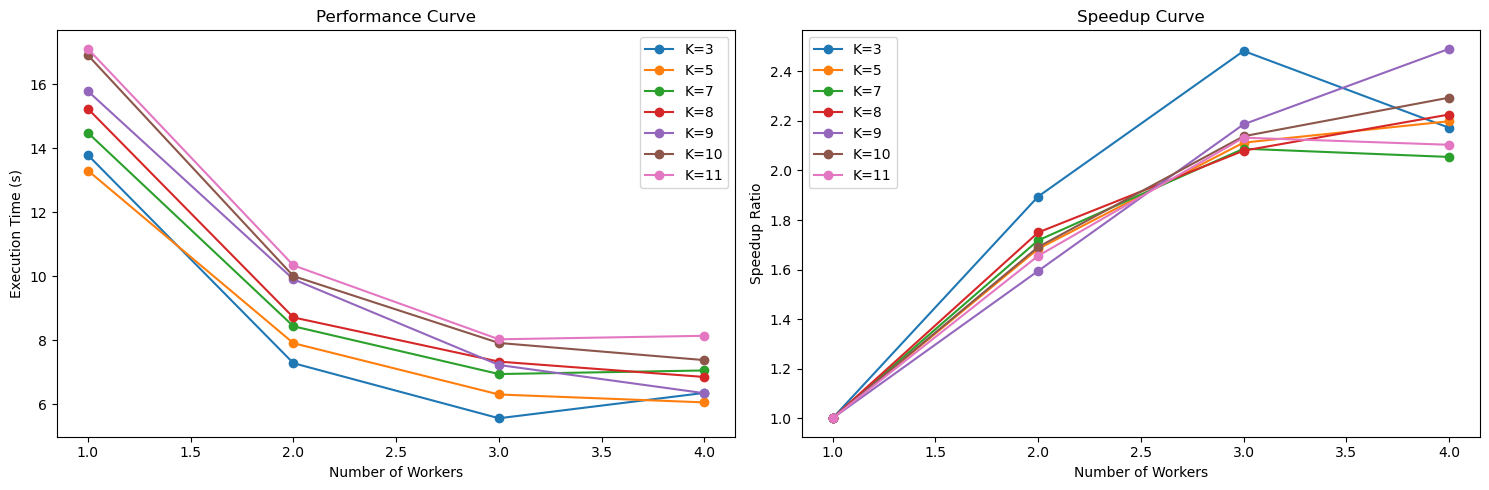

In [6]:
filename = "tot_mnist_shuf.csv"

# Parameters
k_values = [3, 5, 7, 8, 9, 10, 11]
n_workers_range = range(1, 5)  # Test with 1 to 4 workers
n_iter = 10

    
print("\nTesting Parallel Implementation...")
    
# Run performance evaluation
model = ParallelKMeans()
data_rdd= model.parallelReadFile(filename)
results = model.evaluate_performance(data_rdd, k_values, n_workers_range, n_iter)
    
# Plot performance curves
print("\nPlotting Performance Curves...")
plot_performance_curves(results)
    


# Visualising Centroids


Visualizing Clusters for different K values...


Iteration 1/1



Cluster visualization for K=3


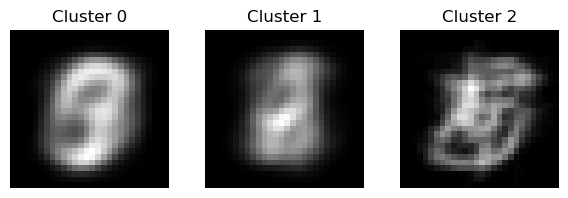

Iteration 1/1



Cluster visualization for K=5


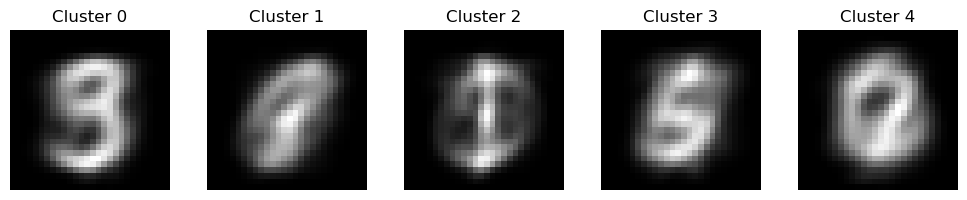

Iteration 1/1



Cluster visualization for K=7


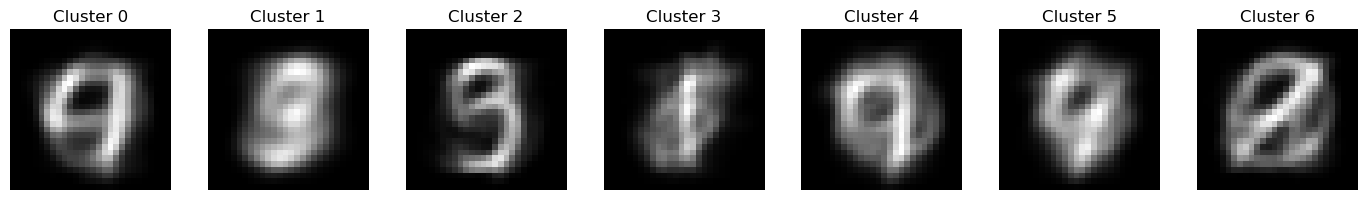

Iteration 1/1



Cluster visualization for K=8


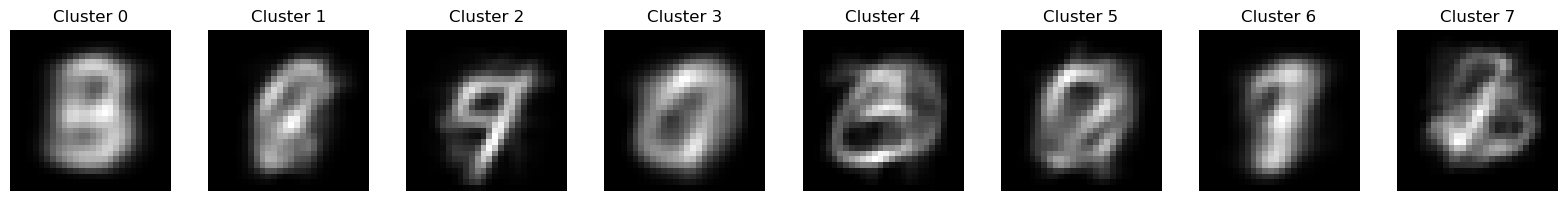

Iteration 1/1



Cluster visualization for K=9


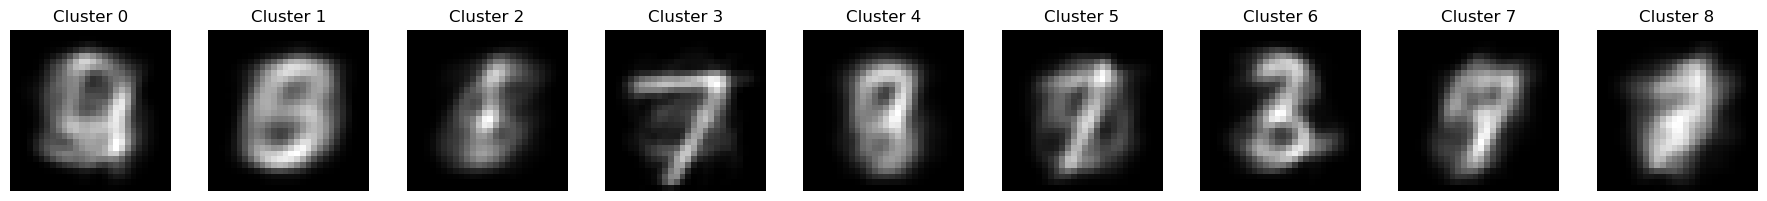

Iteration 1/1



Cluster visualization for K=10


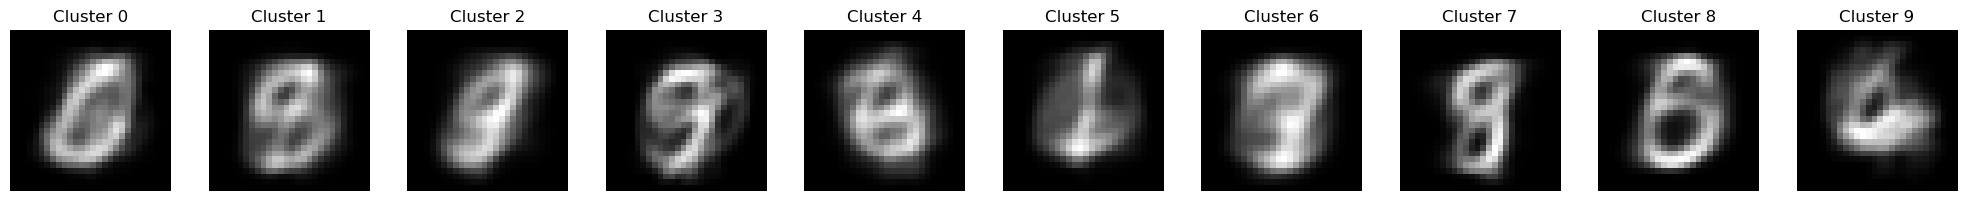

Iteration 1/1



Cluster visualization for K=11


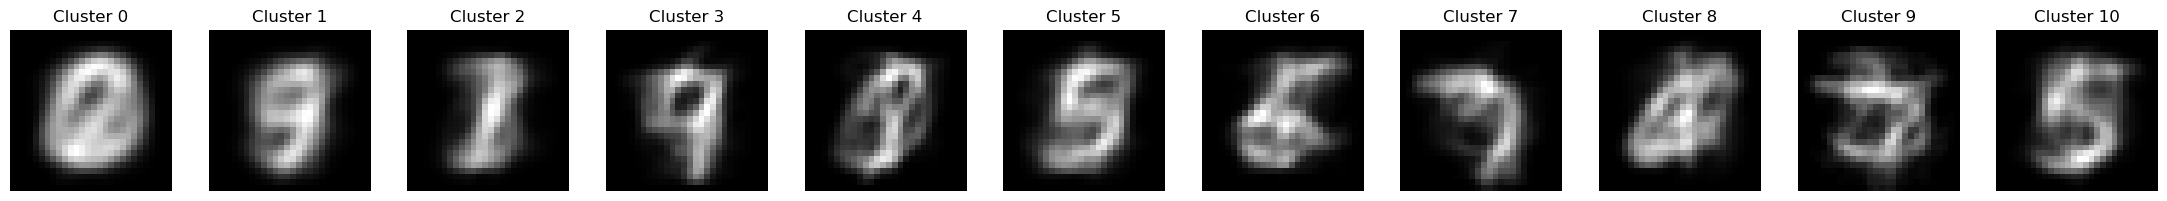


Experiment completed. Results saved to 'kmeans_performance_results.csv'


In [7]:
print("\nVisualizing Clusters for different K values...")
filename = "tot_mnist_shuf.csv"
# Visualize clusters for different K values
model = ParallelKMeans()
spark = SparkSession.builder \
    .appName(f"LogisticRegression_{4}") \
    .config("spark.executor.cores", 4) \
    .config("spark.default.parallelism", 4) \
    .config("spark.sql.shuffle.partitions",4) \
    .getOrCreate()
data_rdd=model.parallelReadFile(filename)
for k in k_values:
    centroids = model.parallelKMeans(data_rdd, k, n_iter)
    print(f"\nCluster visualization for K={k}")
    visualize_clusters(centroids, k)
        
# Save results to CSV
results.to_csv('kmeans_performance_results.csv', index=False)
    
print("\nExperiment completed. Results saved to 'kmeans_performance_results.csv'")